In [9]:
## altering to add eps and time of year
# Importing the libraries

## This version will work to implement reinforcement learning

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas_datareader as web
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras as keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
#from keras. utils.vis_utils import plot_model
from keras.layers import Dense, Dropout, GRU, Bidirectional
#from keras.optimizers import sgd
import math
from sklearn.metrics import mean_squared_error


In [ ]:
from rl.agents import DQNAgent   #our agent to train
from rl.policy import BoltzmannQPolicy  #policy vs value learning
from rl.memory import SequentialMemory  #maintain memory

In [ ]:
def build_agent(model, output):
    policy = BoltzmannQPolicy()
    action_size = 3
    memory = SequentialMemory(limit= 50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=output, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [10]:
# Some functions to help out with
def plot_predictions(test,predicted,padding):
    plt.plot(test, color='red',label='Real Stock Price')
    plt.plot(range(padding, padding + len(predicted)) , predicted, color='blue',label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    

def Directional_error(test, predicted):
    correct = 0
    wrong = 0
    for x in range(len(test)):
        if(x==0):
            continue
        elif((test[x]>test[x-1]) and (predicted[x]>predicted[x-1])):
            ##case in which both went up
            correct +=1
        elif((test[x]<test[x-1]) and (predicted[x]<predicted[x-1])):
            ##case in which both went down
            correct +=1
        elif(test[x] == predicted[x]):
            #case in which both are the same
            correct+=1
        else:
            wrong+=1
    accuracy = round((correct/(correct+wrong))*100 , 2)
    print("The directional accuracy is {}%".format(accuracy))


#**********************************************************************************************
def GRUModelBuild(arrX, arrY, arrDem, daysback):
    # The GRU architecture
    ModelGRU = Sequential()
    
    # First GRU layer with Dropout regularisation  
    ModelGRU.add(GRU(units=50, input_shape=(daysback,arrDem), return_sequences=True, activation='tanh')) #
    ModelGRU.add(Dropout(0.1))
    
    # Second GRU layer
    ModelGRU.add(GRU(units=80, return_sequences=True, activation='tanh' )) #activation='tanh'
    ModelGRU.add(Dropout(0.2))
    
    # Third GRU layer    
    ModelGRU.add(GRU(units=80, return_sequences=True, activation='tanh' )) #activation='tanh'
    ModelGRU.add(Dropout(0.2))    

    ModelGRU.add(GRU(units=80, activation='tanh'))
    ModelGRU.add(Dropout(0.1))

    # The output layer
    ModelGRU.add(Dense(units=1))

    ModelGRU.compile(optimizer='adam' , loss='mean_squared_error')
    
    return ModelGRU

#**********************************************************************************************


def LookbackTrain(arrX, arrY , chars):
    X_train_lookback = []
    y_train = []

    for i in range(54,len(arrX)): ## *************double check this len statement
        X_train_lookback.append(arrX[i-54:i])
        y_train.append(arrY[i,0])

    X_train_lookback, y_train = np.array(X_train_lookback), np.array(y_train)

    # Reshaping X_train for efficient modeling
    X_train_lookback = np.reshape(X_train_lookback, (X_train_lookback.shape[0],X_train_lookback.shape[1],chars))

    #print(len(training_set))
    #print(len(X_train_lookback))
    #print(X_train_lookback.shape[0])
    #print(X_train_lookback.shape[1])
    #print(X_train_lookback.shape)
    #print(X_train_lookback)
    return X_train_lookback, y_train

#*****************************************************************************************************
def LookbackTest(arr, chars):
    X_test_lookback_funct = []

    for i in range(54,len(arr)):  ## *************double check this len statement
        X_test_lookback_funct.append(arr[i-54:i])

    X_test_lookback_funct = np.array(X_test_lookback_funct)
    #print(X_test_lookback)
    X_test_lookback_funct = np.reshape(X_test_lookback_funct, (X_test_lookback_funct.shape[0],X_test_lookback_funct.shape[1],chars))

    #print(X_test_lookback.shape)
    #print(X_test_lookback)
    return X_test_lookback_funct
    
#*****************************************************************************************************

def EvaluationAndPlot(): #currently unused
    None
    return

    


In [11]:
dataset = pd.read_csv('C:/Users/hsipp/Downloads/MCD_stock_data (1).csv', index_col='Date', parse_dates=['Date'])

dataset.index = pd.to_datetime(dataset.index)
dataset['Day'] = dataset.index.dayofyear  # list days as their day of year
dataset = dataset.dropna() # remove all NaNs, due to these being incomplete data sets
dataset['IR'] = dataset['IR'].str.rstrip('%').astype('float') / 100.0  #strip the % from the data and then convert to decimal

dataset = dataset.drop(columns = ['Adj Close']) # Remove adjusted close, may consider as attribute in later version

print(dataset.keys())
#dataset.head()
print(dataset)
#dataset = web.DataReader('AAPL', data_source='yahoo', start = '2009-01-05', end='2019-12-20')






Index(['High', 'Low', 'Open', 'Close', 'Volume', 'EPS', 'IR', 'Day'], dtype='object')
                  High         Low        Open       Close    Volume   EPS  \
Date                                                                         
2008-12-31   62.389999   61.320000   61.639999   62.189999   6230500  0.87   
2009-01-02   64.129997   62.200001   62.380001   63.750000   8652700  0.87   
2009-01-05   63.840000   62.889999   63.259998   63.560001   7692900  0.87   
2009-01-06   64.459999   61.830002   63.990002   62.139999  10855700  0.87   
2009-01-07   62.570000   60.840000   61.930000   61.240002   7910400  0.87   
...                ...         ...         ...         ...       ...   ...   
2021-12-23  267.369995  265.450012  265.920013  265.950012   1509800  2.18   
2021-12-27  268.260010  266.000000  266.470001  268.239990   1485500  2.18   
2021-12-28  269.220001  267.250000  267.579987  267.880005   1304000  2.18   
2021-12-29  269.720001  267.950012  268.450012  268.4899

                  High         Low        Open   EPS  Day
Date                                                     
2008-12-31   62.389999   61.320000   61.639999  0.87  366
2009-01-02   64.129997   62.200001   62.380001  0.87    2
2009-01-05   63.840000   62.889999   63.259998  0.87    5
2009-01-06   64.459999   61.830002   63.990002  0.87    6
2009-01-07   62.570000   60.840000   61.930000  0.87    7
...                ...         ...         ...   ...  ...
2021-12-23  267.369995  265.450012  265.920013  2.18  357
2021-12-27  268.260010  266.000000  266.470001  2.18  361
2021-12-28  269.220001  267.250000  267.579987  2.18  362
2021-12-29  269.720001  267.950012  268.450012  2.18  363
2021-12-30  269.260010  266.700012  269.000000  2.18  364

[3273 rows x 5 columns]
xtrain shape (2704, 65, 5)
Y_train_ready shape (2704,)
Epoch 1/10
85/85 [==============================] - 15s 117ms/step - loss: 0.0092
Epoch 2/10
85/85 [==============================] - 11s 133ms/step - loss: 0.0017
Ep

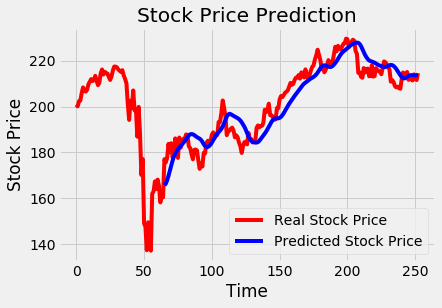

The root mean squared error is 5.974752611705922.
The directional accuracy is 55.08.
Attributes: ['High', 'Low', 'Open', 'EPS', 'Day']
Model Cleared
                  High         Low
Date                              
2008-12-31   62.389999   61.320000
2009-01-02   64.129997   62.200001
2009-01-05   63.840000   62.889999
2009-01-06   64.459999   61.830002
2009-01-07   62.570000   60.840000
...                ...         ...
2021-12-23  267.369995  265.450012
2021-12-27  268.260010  266.000000
2021-12-28  269.220001  267.250000
2021-12-29  269.720001  267.950012
2021-12-30  269.260010  266.700012

[3273 rows x 2 columns]
xtrain shape (2704, 65, 2)
Y_train_ready shape (2704,)
Epoch 1/10
85/85 [==============================] - 17s 136ms/step - loss: 0.0054
Epoch 2/10
85/85 [==============================] - 12s 139ms/step - loss: 0.0013
Epoch 3/10
85/85 [==============================] - 12s 138ms/step - loss: 0.0012
Epoch 4/10
85/85 [==============================] - 12s 144ms/step - l

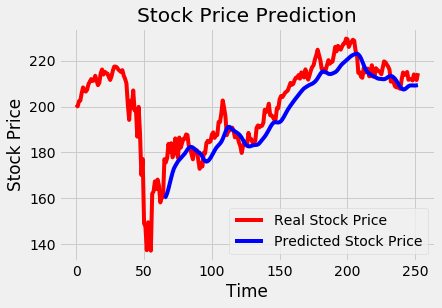

The root mean squared error is 6.8784463213165195.
The directional accuracy is 56.68.
Attributes: ['High', 'Low']
Model Cleared
                  High         Low   EPS  Day
Date                                         
2008-12-31   62.389999   61.320000  0.87  366
2009-01-02   64.129997   62.200001  0.87    2
2009-01-05   63.840000   62.889999  0.87    5
2009-01-06   64.459999   61.830002  0.87    6
2009-01-07   62.570000   60.840000  0.87    7
...                ...         ...   ...  ...
2021-12-23  267.369995  265.450012  2.18  357
2021-12-27  268.260010  266.000000  2.18  361
2021-12-28  269.220001  267.250000  2.18  362
2021-12-29  269.720001  267.950012  2.18  363
2021-12-30  269.260010  266.700012  2.18  364

[3273 rows x 4 columns]
xtrain shape (2704, 65, 4)
Y_train_ready shape (2704,)
Epoch 1/10
85/85 [==============================] - 17s 136ms/step - loss: 0.0090
Epoch 2/10
85/85 [==============================] - 12s 140ms/step - loss: 0.0016
Epoch 3/10
85/85 [============

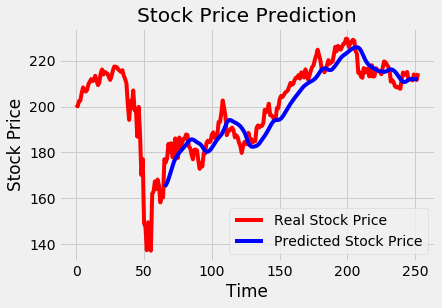

The root mean squared error is 5.9817693557450555.
The directional accuracy is 55.61.
Attributes: ['High', 'Low', 'EPS', 'Day']
Model Cleared
                  High
Date                  
2008-12-31   62.389999
2009-01-02   64.129997
2009-01-05   63.840000
2009-01-06   64.459999
2009-01-07   62.570000
...                ...
2021-12-23  267.369995
2021-12-27  268.260010
2021-12-28  269.220001
2021-12-29  269.720001
2021-12-30  269.260010

[3273 rows x 1 columns]
xtrain shape (2704, 65, 1)
Y_train_ready shape (2704,)
Epoch 1/10
85/85 [==============================] - 18s 141ms/step - loss: 0.0084
Epoch 2/10
85/85 [==============================] - 12s 140ms/step - loss: 0.0012
Epoch 3/10
85/85 [==============================] - 12s 139ms/step - loss: 0.0011
Epoch 4/10
85/85 [==============================] - 12s 141ms/step - loss: 9.5253e-04
Epoch 5/10
85/85 [==============================] - 13s 148ms/step - loss: 8.4620e-04
Epoch 6/10
85/85 [==============================] - 13s 156ms

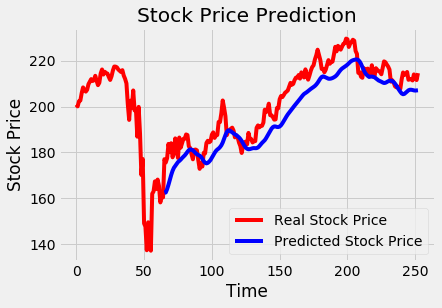

The root mean squared error is 7.862853348122893.
The directional accuracy is 56.68.
Attributes: ['High']
Model Cleared
                  High         Low        Open  Day      IR
Date                                                       
2008-12-31   62.389999   61.320000   61.639999  366  0.0384
2009-01-02   64.129997   62.200001   62.380001    2 -0.0036
2009-01-05   63.840000   62.889999   63.259998    5 -0.0036
2009-01-06   64.459999   61.830002   63.990002    6 -0.0036
2009-01-07   62.570000   60.840000   61.930000    7 -0.0036
...                ...         ...         ...  ...     ...
2021-12-23  267.369995  265.450012  265.920013  357  0.0470
2021-12-27  268.260010  266.000000  266.470001  361  0.0470
2021-12-28  269.220001  267.250000  267.579987  362  0.0470
2021-12-29  269.720001  267.950012  268.450012  363  0.0470
2021-12-30  269.260010  266.700012  269.000000  364  0.0470

[3273 rows x 5 columns]
xtrain shape (2704, 65, 5)
Y_train_ready shape (2704,)
Epoch 1/10
85/85 [==

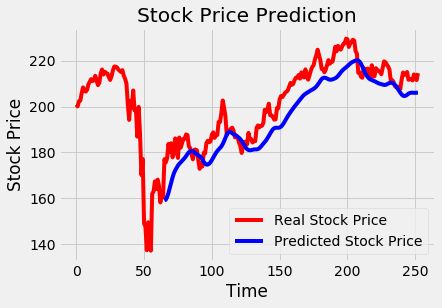

The root mean squared error is 8.683602206385117.
The directional accuracy is 56.15.
Attributes: ['High', 'Low', 'Open', 'Day', 'IR']
Model Cleared
                  High         Low   EPS  Day      IR
Date                                                 
2008-12-31   62.389999   61.320000  0.87  366  0.0384
2009-01-02   64.129997   62.200001  0.87    2 -0.0036
2009-01-05   63.840000   62.889999  0.87    5 -0.0036
2009-01-06   64.459999   61.830002  0.87    6 -0.0036
2009-01-07   62.570000   60.840000  0.87    7 -0.0036
...                ...         ...   ...  ...     ...
2021-12-23  267.369995  265.450012  2.18  357  0.0470
2021-12-27  268.260010  266.000000  2.18  361  0.0470
2021-12-28  269.220001  267.250000  2.18  362  0.0470
2021-12-29  269.720001  267.950012  2.18  363  0.0470
2021-12-30  269.260010  266.700012  2.18  364  0.0470

[3273 rows x 5 columns]
xtrain shape (2704, 65, 5)
Y_train_ready shape (2704,)
Epoch 1/10
85/85 [==============================] - 18s 145ms/step - l

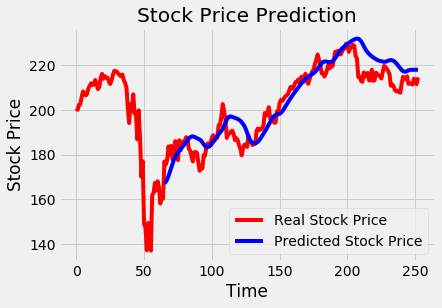

The root mean squared error is 6.633560148466007.
The directional accuracy is 55.61.
Attributes: ['High', 'Low', 'EPS', 'Day', 'IR']
Model Cleared
                  High         Low      IR
Date                                      
2008-12-31   62.389999   61.320000  0.0384
2009-01-02   64.129997   62.200001 -0.0036
2009-01-05   63.840000   62.889999 -0.0036
2009-01-06   64.459999   61.830002 -0.0036
2009-01-07   62.570000   60.840000 -0.0036
...                ...         ...     ...
2021-12-23  267.369995  265.450012  0.0470
2021-12-27  268.260010  266.000000  0.0470
2021-12-28  269.220001  267.250000  0.0470
2021-12-29  269.720001  267.950012  0.0470
2021-12-30  269.260010  266.700012  0.0470

[3273 rows x 3 columns]
xtrain shape (2704, 65, 3)
Y_train_ready shape (2704,)
Epoch 1/10
85/85 [==============================] - 18s 147ms/step - loss: 0.0132
Epoch 2/10
85/85 [==============================] - 14s 163ms/step - loss: 0.0014
Epoch 3/10
85/85 [==============================] 

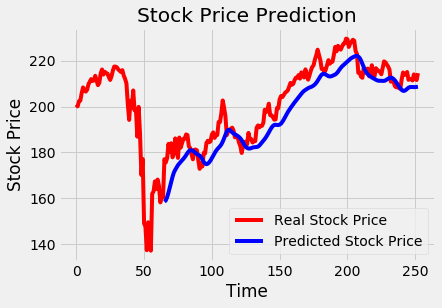

The root mean squared error is 7.6861631517578966.
The directional accuracy is 55.61.
Attributes: ['High', 'Low', 'IR']
Model Cleared
                  High         Low  Day      IR
Date                                           
2008-12-31   62.389999   61.320000  366  0.0384
2009-01-02   64.129997   62.200001    2 -0.0036
2009-01-05   63.840000   62.889999    5 -0.0036
2009-01-06   64.459999   61.830002    6 -0.0036
2009-01-07   62.570000   60.840000    7 -0.0036
...                ...         ...  ...     ...
2021-12-23  267.369995  265.450012  357  0.0470
2021-12-27  268.260010  266.000000  361  0.0470
2021-12-28  269.220001  267.250000  362  0.0470
2021-12-29  269.720001  267.950012  363  0.0470
2021-12-30  269.260010  266.700012  364  0.0470

[3273 rows x 4 columns]
xtrain shape (2704, 65, 4)
Y_train_ready shape (2704,)
Epoch 1/10
85/85 [==============================] - 18s 138ms/step - loss: 0.0081
Epoch 2/10
85/85 [==============================] - 12s 144ms/step - loss: 0.001

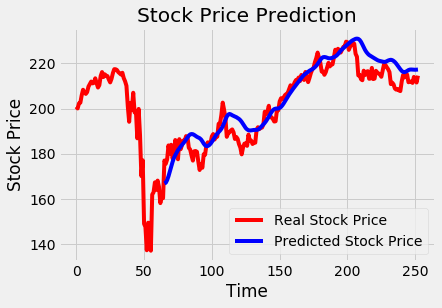

The root mean squared error is 6.252846137900396.
The directional accuracy is 56.15.
Attributes: ['High', 'Low', 'Day', 'IR']
Model Cleared


In [15]:
## User input region and or section to handle the varying of arrays
## this may need to be added above.


lookback_days = 65

#********************************************************************************************
# Here is a set of different combinations of attributes that will be used for training models
# Volume has been exluded for the time being.
characteristics = {}
characteristics["arrayset1"] = ['High', 'Low', 'Open', 'EPS', 'Day']
#characteristics["arrayset2"] = ['High', 'Low', 'Open', 'Day']
#characteristics["arrayset3"] = ['High', 'Low', 'Day']
#characteristics["arrayset4"] = ['High', 'Low', 'Open']
#characteristics["arrayset5"] = ['High', 'Low', 'Open', 'Volume', 'Day'] 
#characteristics["arrayset6"] = ['High', 'Low', 'Open', 'Volume', 'EPS']
#characteristics["arrayset7"] = ['High', 'Low', 'Open', 'Volume', 'Day', 'EPS']
characteristics["arrayset8"] = ['High', 'Low']
characteristics["arrayset9"] = ['High', 'Low', 'EPS', 'Day']
characteristics["arrayset10"] = ['High']
characteristics["arrayset11"] = ['High', 'Low', 'Open', 'EPS', 'Day', 'IR']
characteristics["arrayset11"] = ['High', 'Low', 'Open', 'Day', 'IR']
characteristics["arrayset12"] = ['High', 'Low', 'EPS', 'Day', 'IR']
characteristics["arrayset13"] = ['High', 'Low', 'IR']
characteristics["arrayset14"] = ['High', 'Low', 'Day', 'IR']
#********************************************************************************************

options = list(characteristics.keys()) # make a list out of the keys so they can be better tracked and iterated through.

#print(options[0])

output_var = pd.DataFrame( dataset['Close'] )

#dataset = dataset.drop(columns = ['Close'])  ##do this in a different way

#print("New implementation:", Y_train)
#this scaling up here sets the fit values so that they stay consistent



## implement a loop here********************************************

for j in range(len(options)):
    numChars = len(characteristics[options[j]])    
    
    Y_train = output_var[:'2019'].values
    Y_test = output_var['2020':'2020'].values
    
    #print(i)
    #print(options[j])
    #print(X_Values)
    
    X_Values = pd.DataFrame( dataset[characteristics[options[j]]])
    print(X_Values)
    X_train = X_Values[:'2019'].values
    X_test = X_Values['2020':'2020'].values  ## grouping day of year in and scaling...
    #print(X_test)


    # Scaling the training set*************************************************************************
    #sc = MinMaxScaler(feature_range=(0,1)) 
    scX = MinMaxScaler(feature_range=(0,1))
    scY = MinMaxScaler(feature_range=(0,1))
    
    X_train = scX.fit_transform(X_train)
    X_test = scX.transform(X_test)    
    
    Y_train = scY.fit_transform(Y_train)    
    #Y_test = scY.transform(Y_test) 
    
    ## data needs to all be scaled together.************************************************************
    
    
    ##send data to look back functions****************************************************************************
    #X_test_lookback = LookbackTest(X_test, numChars)
    
    #X_train_lookback, y_train = LookbackTrain(X_train, Y_train , numChars)
    
    
    #*************************************************************************************************************
    X_test_lookback = []
    Y_test_ready = []

    for i in range(lookback_days,len(X_test)):  ## *************double check this len statement
        X_test_lookback.append(X_test[i-lookback_days:i])
        Y_test_ready.append(Y_test[i,0]) ## this line is what causes the need for graph shfiting
       

    X_test_lookback, Y_test_ready = np.array(X_test_lookback),np.array(Y_test_ready)
    #print(len(options[j]))
    X_test_lookback = np.reshape(X_test_lookback, (X_test_lookback.shape[0],X_test_lookback.shape[1],numChars))

    #*************************************************************************************************************
    
    
    X_train_lookback = []
    Y_train_ready = []
    #print(training_set_scaled[54-54:54, 1])
    
    for i in range(lookback_days,len(X_train)): ## *************double check this len statement
        X_train_lookback.append(X_train[i-lookback_days:i])
        Y_train_ready.append(Y_train[i,0])

    X_train_lookback, Y_train_ready = np.array(X_train_lookback), np.array(Y_train_ready)
    #print(X_train_lookback)
    # Reshaping X_train for efficient modeling
    X_train_lookback = np.reshape(X_train_lookback, (X_train_lookback.shape[0],X_train_lookback.shape[1],numChars))
    
    
    #*************************************************************************************************************
    
 
    #print(X_train_lookback)
    #print(y_train)
    #print(numChars)
    
    print("xtrain shape", X_train_lookback.shape)
    print("Y_train_ready shape", Y_train_ready.shape)
    Model1 = GRUModelBuild(X_train_lookback, Y_train_ready, numChars, lookback_days) 
    #print(Model1.summary()) #this will print out the structure of the GRU
    
    
    #dqn = build_agent(Model1, )
    
    
    Model1.fit(X_train_lookback, Y_train_ready, epochs = 10) # ,batch_size=1
    
    
    print("xtestshape", X_test_lookback.shape)
    GRU_predicted_stock_price = Model1.predict(X_test_lookback)
    
    # Visualizing the results for GRU
    GRU_predicted_stock_price = scY.inverse_transform(GRU_predicted_stock_price)  
    
    plot_predictions(Y_test[0:,0], GRU_predicted_stock_price, 65)

    # Evaluating GRU rsme
    return_rmse(Y_test_ready, GRU_predicted_stock_price)
   
    Directional_error(Y_test_ready, GRU_predicted_stock_price)
    print("Attributes:", characteristics[options[j]]) #print what characteristics were used

    
    keras.backend.clear_session()#delete the GRU and clear all weight data
    print("Model Cleared")
    
    #print("y_training set: \n", y_training_set, "\n\n")
    #print(training_set_scaled)

    if(j == 2):
        break
    

